# **Assignment 3  (From Scratch)**

## **Penalized Logistic Ridge Regression CV with Batch Gradient Decent**

- **Programmers:**
  - Shaun Pritchard
  - Ismael A Lopez
- **Date:** 11-15-2021
- **Assignment:** 3
- **Prof:** M.DeGiorgio

<hr>

### **Overview: Assignment 3**

- In this assignment you will still be analyzing human genetic data from 𝑁 = 183 training
observations (individuals) sampled across the world. The goal is to fit a model that can predict
(classify) an individual’s ancestry from their genetic data that has been projected along 𝑝 = 10
top principal components (proportion of variance explained is 0.2416) that we use as features
rather than the raw genetic data

- Using ridge regression, fit a penalized (regularized) logistic (multinomial) regression with model parameters obtained by batch gradient descent. Based on K = 5 continental ancestries (African, European, East Asian, Oceanian, or Native American), predictions will be made. Ridge regression will permit parameter shrinkage (tuning parameter 𝜆 ≥ 0) to mitigate overfitting. In order to infer the bestfit model parameters on the training dataset, the tuning parameter will be selected using five-fold cross validation. After training, the model will be used to predict new test data points.



## **Imports**

> Import libaries and data

In [ ]:
#Math libs
from math import sqrt
from scipy import stats
from numpy import median
from decimal import *
import os
# Data Science libs
import numpy as np
import pandas as pd
# Graphics libs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Timers
# !pip install pytictoc
# from pytictoc import TicToc

In [ ]:
# Import training and test datasets
train_df = pd.read_csv('TrainingData_N183_p10.csv')
test_df = pd.read_csv('TestData_N111_p10.csv')

In [ ]:
# Validate traning data import correclty
train_df.head(2)

In [ ]:
# Validate testing data import correclty
test_df.head(2)

## **Data Pre-Proccessing**

- Pre-proccess test and training datasets
- Impute categorical variables in features
- Validate correct output of test data

In [ ]:
# recode the categories
data = train_df['Ancestry'].unique().tolist()
num_features = len(data)
train_df['Ancestry2'] = train_df['Ancestry'].apply(lambda x: data.index(x))


In [ ]:
# Validate training data set
train_df.head(2)

In [ ]:
# Shape trianing data
train_df.shape

## **Seperate X Y Predictors and Responses**
 - Seperate predictors from responses
 - Validate correct output

In [ ]:
# Seperate dependant categorical feature data for training and test data set for later use
Y_train_names = train_df['Ancestry'].tolist()
Y_test_names = test_df['Ancestry'].tolist()

In [ ]:
# Separate training feature predictors from responses
X_train = np.float32(train_df.to_numpy()[:, :-2])
Y_train = train_df['Ancestry2'].to_numpy()

In [ ]:
# Separate test feature predictors from responses
X_test = np.float32(test_df.to_numpy()[:, :-1])

In [ ]:
X_train.shape

## **Set Global Vairibles**
- λ = tunning parameters
- α = learning rate
- k = number of folds
- n_itters = nu mber of itterations
- X_p = predictor vlaues from training data
- Y_p = response values from training data

In [ ]:
# Set local variables

# Tuning Parms
λ  =  10 ** np.arange(-4., 4.)

# learning rate
α =  1e-4

# K-folds
k = 5


# Itterations
n_iters = 10000 

# Set n x m matrix predictor variable
X_p = X_train

# Set n vector response variable
Y_p  = Y_train

## **Instantiate Data**
- Handle logic and set variables needed for calculating ridge logistic regression
- Handle logic and set variables for batch gradient descent
- Handle logic and set variables for cross-validation

In [ ]:
# Encode response variable from CV design matrix for cross vlaidation
def imputeResponse(response_vector, num_features):
   response_vector = np.int64(response_vector)
   X1 = response_vector.shape[0]
   response_mat = np.zeros([X1, num_features])
   response_mat[np.arange(X1), response_vector] = 1
   return response_mat

In [ ]:
# Method to handle randomization of training data predictors and responses
def randomizeData(X_p, Y_p):
    data = np.concatenate((X_p, Y_p[:, None]), 1)
    np.random.shuffle(data)
    return data[:, :-1], data[:, -1]

In [ ]:
# Randomize predictors and responses into new vairables
x, y = randomizeData(X_p, Y_p)

In [ ]:
# Set Global variable for samples and number of X = N X M features
X1 = x.shape[0]
X2 = x.shape[1]     

In [ ]:
# Get number of training feature classes = 5
num_features = np.unique(y).size

In [ ]:
 # Call method imputation method on training response variables
 y = imputeResponse(y, num_features)      

In [ ]:
# Store 5 K-fold cross validation results in symetric matrices
CV = np.zeros([k, len(λ)])

In [ ]:
# Number of validation sample index values based on k-folds 
val_samples = int(np.ceil(X1 / k)) 
test_i = list(range(0, X1, val_samples))

In [ ]:
# Create a 𝛽 zero matrix to store the trained predictors  
𝛽 = np.zeros([k, len(λ), X2 + 1, num_features])

## **Implement logic**
- Main functions to handle logic within the preceding algorithms

In [ ]:
# Standardize X coefficients
def standardize(x, mean_x, std_x):
   return (x - mean_x) / std_x 

In [ ]:
# Concatenate ones column matrix with X coefficiants
def intercept(x):
    col = np.ones([x.shape[0], 1])
    return np.concatenate((col, x), 1)

In [ ]:
# Predict standardize expotential X values from intercepts
def predict(x):
  x = standardize(x, mean_x, std_x)
  x = intercept(x)

  X_p = np.exp(np.matmul(x, 𝛽x))
  return X_p / np.sum(X_p, 1)[:, None]

In [ ]:
# Splitting the data into k groups resampling method
def cv_folds(i_test):
    if i_test + val_samples <= X1:
        i_tests = np.arange(i_test, i_test + val_samples)
    else:
        i_tests = np.arange(i_test, X1)
            
    x_test = x[i_tests]
    x_train = np.delete(x, i_tests, axis = 0)

    
    y_test = y[i_tests]
    y_train = np.delete(y, i_tests, axis = 0)
    return x_train, x_test, y_train, y_test

In [ ]:
# Calculate model CV score 
def score(x, y, 𝛽x):
    # Compute exponent values of X coef and BGD unnormilized probality matrix
    U = np.exp(np.matmul(x, 𝛽x))
    # Calculate sum unnormilized probality / sum unnormilized matrix by 1
    P = U / np.sum(U, 1)[:, None]
    # Calulate to cost error score
    err = -(1 / x.shape[0]) * np.sum(np.sum(y * np.log10(P), 1))
    return err

## **Batch Gradient Descent**
> Alorithm 1 used for this computation

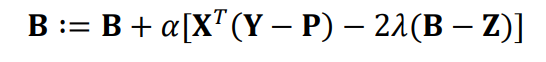


In [ ]:

def BGD(x, y, 𝛽x, lamb):
    # Unormalized class probability matrix
    U = np.exp(np.dot(x, 𝛽x))
    # Normalized class probability matrix
    P = U / np.sum(U, 1)[:, None]
    # K intercept matrix
    Z = 𝛽x.copy()
    Z[1:] = 0
    # Update parameter matrix
    𝛽x = 𝛽x + α * (np.matmul(np.transpose(x), y - P) - 2 * lamb * (𝛽x - Z))
    return 𝛽x

## **CV Ridge Penlized Logistic Regression**
> - Compute ridge-penalized logistic regression with cross vlaidation
- Performing a ridge-penalized logistic regression fit to training data
{(𝑥1, 𝑦1), (𝑥2, 𝑦2), … , (𝑥𝑁, 𝑦𝑁)} is to minimize the cost function


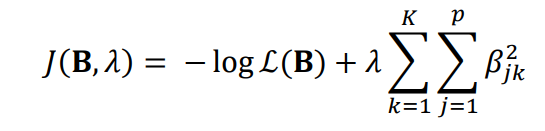

In [ ]:
# Compute ridge-penalized logistic regression with cross vlaidation
for i_lambda, lamb in enumerate(λ):
    for i_fold, i_test in zip(range(k), test_i):
        
        # Validates and trains the CV iteration based on the validation and training sets.
        x_train, x_test, y_train, y_test = cv_folds(i_test)

        # Standardize x and center y  5 K-fold trianing and test data
        mean_x, std_x = np.mean(x_train, 0), np.std(x_train, 0)
        
        # implement standardize X training and test sets
        x_train = standardize(x_train, mean_x, std_x)
        x_test = standardize(x_test, mean_x, std_x)
                
        # Add training and test intercept column to the design matrix
        x_train = intercept(x_train)
        x_test = intercept(x_test)

        # initialize Beta coef for lambdas and fold
        𝛽x =  np.zeros([X2 + 1, num_features])
        
        # Loop through beta and lambdas with batch gradient decent
        for iter in range(n_iters):
            𝛽x = BGD(x_train, y_train, 𝛽x, lamb)

        # Score CV cost error tp the model and store the values 
        CV[i_fold, i_lambda] = score(x_test, y_test, 𝛽x)
                
        # Save the updated coefficient vectors 𝛽x
        𝛽[i_fold, i_lambda] = 𝛽x

## **Deliverable 1**
> Illustrate the effect of the tuning parameter on the inferred ridge regression
coefficients by generating five plots (one for each of the 𝐾 = 5 ancestry classes) of 10 lines
(one for each of the 𝑝 = 10 features)

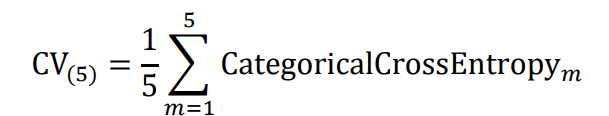

In [ ]:
# Plot tuning parameter on the inferred ridge regression coefficients
𝛽μ = np.mean(𝛽, 0)
sns.set(rc = {'figure.figsize':(15,8)})
for i, c in enumerate(data):
    𝛽μk = 𝛽μ[..., i]
    sns.set_theme(style="whitegrid")
    sns.set_palette("mako")
    for j in range(1, 1 + X2):
        sns.lineplot( x=λ, y=𝛽μk[:, j], palette='mako',   label = 'PC{}'.format(j) )
        sns.set()
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.09, 1), loc='upper left')
    plt.xlabel('Log Lambda')
    plt.ylabel('Coefficient Values')
    plt.suptitle('Inferred Ridge Regression Coefficient Tuning Parameters of' + ' ' + c + ' ' + 'Class')
    for l in range(i):
      # Output Deliverable 1
      plt.savefig("Assignment3_Deliverable1.{}.png".format(l))
    plt.show()
    
    
   
    

## **Deliverable 2**
> Illustrate the effect of the tuning parameter on the cross validation error by generating a plot with the 𝑦-axis as CV(5) error, and the 𝑥-axis the corresponding log-scaled
tuning parameter value log10(𝜆) that generated the particular CV(5) error.

In [ ]:
# Compute tuning parameter on the cross validation error
err = np.std(CV, 0) / np.sqrt(CV.shape[0])
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")
sns.set_palette("icefire")
sns.pointplot(x=λ, y=np.mean(CV, 0),yerr = err)
sns.set()
plt.xlabel('log10(lambda)')
plt.ylabel('CV(5) error')
plt.xscale('log')
plt.yscale('log')
plt.suptitle('Effect of the uning parameter on the cross validation error log10(lambda)')
plt.savefig("Assignment3_Deliverable2.png")
plt.show()


### **Retrain model with best lambda**

In [ ]:
# Set array of indices into the best lambda
best_λ = λ[np.argmin(np.mean(CV, 0))]

In [ ]:
# Set standaridzed variables
mean_x, std_x = np.mean(x, 0), np.std(x, 0)

In [ ]:
# Implement standarization of predictors and copy response variables
x = standardize(x, mean_x, std_x)
x = intercept(x)
y = y.copy()

In [ ]:
# Set zeros matrix to coef and retiran model on batch gradient decent
𝛽x = np.zeros([X2 + 1, num_features])
for iter in range(n_iters):
   𝛽x = BGD(x, y, 𝛽x, best_λ)

## **Deliverable 3**
> Indicate the value of 𝜆 value that generated the smallest CV(5) error

**Optimal lambda**

In [ ]:
# Plot lowest optimal lambda
palette = sns.color_palette('mako')
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")
ak = Decimal(best_λ)
plt.plot(λ)
sns.set_palette("icefire")
sns.countplot(data=λ)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log10(lambda)')
plt.ylabel('Best Lambda')
plt.suptitle('Lowest optimal Lamda value:= log_1e{:.1f} = {}'.format(ak.log10(), best_λ))
print('Optimal lambda value:= {}'.format(best_λ))
plt.savefig("Assignment3_Deliverable3-1.png")

**Accuracy on training classifier**

In [ ]:

#Implement Prediction function
ŷ_p = predict(X_train)
# Return the maximum value along a given y axis
ŷ0 = np.argmax(ŷ_p, 1)
# Return mean traning accuaracy 
μ = np.mean(ŷ0 == Y_train)
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")
plt.plot(ŷ0)
sns.set_palette("icefire")
sns.boxplot(data=ŷ0 -μ**2)
plt.xscale('log')
plt.xlabel('log10(lambda)')
plt.ylabel('Best Lambda')
plt.suptitle('Classifier Training Accuracy:= {}'.format(μ))
plt.savefig("Assignment3_Deliverable3-2.png")
# print('Classifier Training Accuracy: {}'.format(μ))

## **Retrain model on the entire dataset for optimal 𝜆**
> - Given the optimal 𝜆, retrain your model on the entire dataset of 𝑁 = 183 observations to obtain an estimate of the (𝑝 + 1) × 𝐾 model parameter matrix as 𝐁̂ and make predictions of the probability for each of the 𝐾 = 5 classes for the 111 test individuals located in TestData_N111_p10.csv.
- Add probability predictions to the test dataframe

In [ ]:
# Create new test predicotr and response variables ŷ
ŷ_test = predict(X_test)
Y_class = np.argmax(ŷ_test, 1)

In [ ]:
# Re-lable feature headers and add new class prediction index column
new_colNames = ['{}_Probability'.format(c_name) for c_name in data] + ['ClassPredInd']

In [ ]:
# Implemnt index array of probabilities
i_prob = np.concatenate((ŷ_test, Y_class[:, None]), 1)

In [ ]:
# Create New dataframe for probality indeces
df2 = pd.DataFrame(i_prob, columns = new_colNames)

In [ ]:
# Concat dependant Ancestory features to dataframe
dep_preds = pd.concat([test_df['Ancestry'], df2], axis = 1)

In [ ]:
# Add new 
dep_preds['ClassPredName'] = dep_preds['ClassPredInd'].apply(lambda x: data[int(x)])

In [ ]:
# Validate Probability predictions dataframe
dep_preds.head()

In [ ]:
# Slice prediction and set new feature vector column variable
prob_1 = dep_preds.loc[:, 'Ancestry':'NativeAmerican_Probability']

In [ ]:
# Unpivot convert dataFrame to long format
prob_2 = pd.melt(prob_1, id_vars = ['Ancestry'], var_name = 'Ancestry_Predictions', value_name = 'Probability')

In [ ]:
# Test for true probability
prob_2['Ancestry_Predictions'] = prob_2['Ancestry_Predictions'].apply(lambda x: x.split('Prob')[0])

In [ ]:
# Validate dataframe
prob_2.head(5)

In [ ]:
# Validate dataframe features
print('Describe Columns:=', prob_2.columns, '\n')
print('Data Index values:=', prob_2.index, '\n')
print('Describe data:=', prob_2.describe(), '\n')

## **Deliverable 4**
>  Given the optimal 𝜆, retrain your model on the entire dataset of 𝑁 = 183 observations to obtain an estimate of the (𝑝 + 1) × 𝐾 model parameter matrix as 𝐁̂ and make predictions of the probability for each of the 𝐾 = 5 classes for the 111 test individuals located in TestData_N111_p10.csv. 

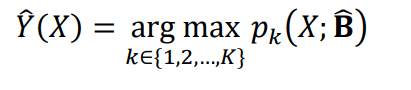

In [ ]:
# Plot Probality prediction matrix
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
sns.barplot(data = prob_2[prob_2['Ancestry'] != 'Unknown'],color = 'r', x = 'Ancestry', y = 'Probability', hue = 'Ancestry_Predictions', palette = 'mako')
plt.xlabel('Ancestory Classes')
plt.ylabel('Probability')
plt.suptitle('Probabilty of Ancestor classes')
plt.savefig("Assignment3_Deliverable4.png")
plt.show()

## **Deliverable 5**
**How do the class label probabilities differ for the Mexican and African American samples when compared to the class label probabilities for the unknown samples?**

> In comparison to the class label probabilities for the unknown samples, those with unknown ancestry show a probability close to or equal to one while the other classes show a probability close to zero or less than one. African American samples showed similar results. The model assigned high probabilities to the African ancestry class for each of these samples. However, both Native American and European ancestry contribute high probabilities to the Mexican population on average with Native American slightly higher than European. 